## OK... LET CHOICE 2 DIFFERENT LABELS FROM DATA


In [50]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


  
url='https://raw.githubusercontent.com/srk-practicum/2022-knu-nlp/kachaikin_branch/Task1_Kachaikin/root2ai%20-%20Data.csv'
df = pd.read_csv(url)

U=list(df['Target'])
A = list(set(df['Target']))

#Let's chose 2 very different labels, for example Bigdata and Cyber Security

V = list(df['Text'])

R = [[V[i],U[i]] for i in range(len(U))]
new_frame = [i for i in R if i[1]== 'Bigdata' or i[1]== 'Cyber Security']
new_frame_texts = [i[0] for i in new_frame]
new_frame_labels = [i[1] for i in new_frame]
new_frame_labels_asreal = []
for i in new_frame_labels:
    if i == 'Bigdata':
      new_frame_labels_asreal.append(1.0)
    elif i == 'Cyber Security':
      new_frame_labels_asreal.append(0.0)
# Okey, now we have new dataframe with labels Bigdata = 1.0 and Cyber Security = 0.0
df = pd.DataFrame(data = {'Text':new_frame_texts , 'Target':new_frame_labels_asreal})

#Let's watch how distributed labels
number_of_bd = 0
number_of_cs = 0
for i in list(df['Target']):
  if float(i) == 1.0:
    number_of_bd+=1
  elif float(i) == 0.0:
    number_of_cs +=1

text1 = ''
for i in new_frame_texts:
  text1+=i

df



,Text,Target
0,while clich observe data gold century consider...,1.0
1,scale businesses volume data great humans hand...,1.0
2,this especially true today current situation p...,1.0
3,data processing allows companies complete comp...,1.0
4,nascent data technologies machine learning alr...,1.0
...,...,...
4902,understand potential install leading security ...,0.0
4903,suggest digital payment protection building ro...,0.0
4904,also ensure they strong unique keep operating ...,0.0
4905,hence government focus well basic security,0.0


# SOME PREPROCESSING WITH **NLTK**

In [51]:
from nltk import WordNetLemmatizer
import re
import string
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

U = list(df['Text'])
lemmatizer = nltk.WordNetLemmatizer()
V = list(df['Target'])

U_f = []
for j in U:
  R = nltk.word_tokenize(j)
  Y = [lemmatizer.lemmatize(i) for i in R]
  StrY = " ".join(Y)
  U_f.append(StrY)

stop_words = stopwords.words("english")

def cleaning(data):
    
    filtered = re.sub("@\S+", " ", data)  # remove mentions
    filtered = re.sub("https*\S+", " ", filtered) # remove url
    filtered = re.sub("#\S+", " ", filtered) # remove hashtags
    filtered = re.sub("\d", " ", filtered) # remove all numbers
    filtered = re.sub('[%s]+' % re.escape(string.punctuation), ' ', filtered)  # remove punctuation
    filtered = re.sub('\n', ' ', filtered) # remove new lines       
    filtered = re.sub('\s{2,}',' ', filtered) # remove extra spaces
    
    filtered = filtered.lower()
    
    filtered = ' '.join([word for word in filtered.split(' ') if word not in stop_words and len(word)>2 and word.isalpha() == True])
    
    return filtered

df = pd.DataFrame(data = {'Text':[cleaning(i) for i in U_f], 'Target':V})

df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,Target
0,clich observe data gold century considered rol...,1.0
1,scale business volume data great human handle ...,1.0
2,especially true today current situation people...,1.0
3,data processing allows company complete comple...,1.0
4,nascent data technology machine learning alrea...,1.0
...,...,...
4902,understand potential install leading security ...,0.0
4903,suggest digital payment protection building ro...,0.0
4904,also ensure strong unique keep operating antiv...,0.0
4905,hence government focus well basic security,0.0


# OTHER METHOD FOR VECTORIZATION

In [67]:
# First, let do vocabulary of texts
import nltk
from nltk import FreqDist

Texts = ''
for i in df['Text']:
  Texts+=' '+i
unique_tokens = list(set(Texts.split(' ')))


text_tokens = nltk.word_tokenize(Texts)



vocab_with_freq = {word:Texts.count(word) for word in unique_tokens if word.isalpha()}


vocab_with_freq_listed = list(vocab_with_freq.items())


#vocabular 
vocab_with_freq_listed = sorted(vocab_with_freq_listed, reverse = True, key = lambda x:x[1])
vocab_with_freq_listed


Vocabulary = [i[0] for i in vocab_with_freq_listed]




def text_encoding(text):
  tokens = nltk.word_tokenize(text)
  return [Vocabulary.index(i) for i in tokens]

def text_decoding(encoded_text):
  text = ''
  for i in encoded_text:
    text+=Vocabulary[i]+' '
  return text

df_new= pd.DataFrame({'Text':[text_encoding(i) for i in list(df['Text'])], 'Target':list(df['Target'])})

len(Vocabulary)

5304

## Scikit-learn methods

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_new['Text'], 
                                                    df_new['Target'], test_size=0.2 ,
                                                    random_state=42)


X_train, X_test, y_train, y_test = X_train, X_test, np.asarray(y_train).astype('float32'), np.asarray(y_test).astype('float32')


X_train

3097                                   [125, 30, 64, 688]
1610                                               [3245]
621     [437, 142, 16, 64, 3978, 52, 2275, 0, 2239, 15...
3308                                    [90, 77, 21, 236]
3214                           [1759, 2931, 167, 50, 126]
                              ...                        
4426    [431, 18, 34, 219, 3179, 4563, 46, 953, 953, 2...
466     [231, 294, 117, 121, 652, 231, 294, 1306, 357,...
3092                                     [431, 18, 3, 76]
3772                        [5, 22, 434, 2218, 2395, 509]
860     [82, 170, 3037, 312, 2886, 3819, 136, 1812, 3762]
Name: Text, Length: 4416, dtype: object

## Finally... Model for TASK3

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




X_train_vectorized = keras.preprocessing.sequence.pad_sequences(X_train, maxlen =80)

model = keras.Sequential()
model.add(layers.Embedding(5400,128))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"],
)
model.summary()




history = model.fit(X_train_vectorized, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 128)         691200    
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 888,961
Trainable params: 888,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
28/28 [=============================

In [90]:
X_test_vectorized = keras.preprocessing.sequence.pad_sequences(X_test, maxlen =80)

score = model.evaluate(X_test_vectorized, y_test, verbose=0) 

print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.3524414002895355
Test accuracy: 0.8940936923027039


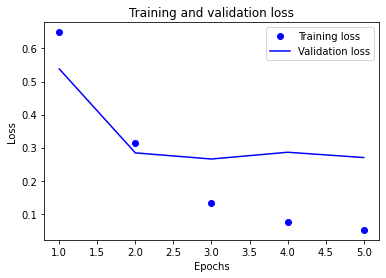

In [91]:
history_dict = history.history
history_dict.keys()
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()